# model 1





In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

# keras import
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
# from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import concatenate, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.utils import to_categorical
from keras.models import load_model
from datetime import time


from keras.layers import Dense, Flatten
from keras.layers import LSTM, Dropout, Input, Conv1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import he_normal
# fix random seed for reproducibility
from keras.models import load_model
from sklearn.model_selection import train_test_split
np.random.seed(7)
from keras.preprocessing.text import Tokenizer
from scipy.sparse import hstack
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
#from gensim import corpora
import pickle

from tqdm import tqdm
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
d = pd.read_csv('/content/drive/My Drive/AAIC assingments/preprocessed_data.csv')
d.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(d, test_size=0.3)

In [ ]:
train_df.shape, test_df.shape

((76473, 9), (32775, 9))

In [ ]:
x_train_essay_text = train_df.essay.values.tolist()
x_test_essay_text = test_df.essay.values.tolist()

In [ ]:
# tokenizing 
# https://stackoverflow.com/questions/52126539/using-pretrained-gensim-word2vec-embedding-in-keras
# https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
t = Tokenizer()
t.fit_on_texts(x_train_essay_text)
vocab_size = len(t.word_index) + 1
print(len(t.word_index))

49086


In [ ]:
#this code is taken from below link and changes were made as per our requirement
#https://github.com/xSachinBharadwajx/LSTM-DonorsChoose/blob/
def load_embedding(filename):

    # load embedding into memory, skip first line
    file = open(filename,encoding='utf8')
    lines = file.readlines()[1:]
    
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

# load embedding from file
raw_embedding = load_embedding('/content/drive/My Drive/AAIC assingments/glove.6B.300d.txt')
# raw_embedding = load_embedding('glove.42B.300d.txt')

# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, t.word_index)
where_are_NaNs = np.isnan(embedding_vectors)
embedding_vectors[where_are_NaNs] = 0

In [ ]:
# enocde it to sequences
encoded_docs = t.texts_to_sequences(x_train_essay_text)

# padding
max_length = len(max(x_train_essay_text, key=len).split(' '))

x_train_text = sequence.pad_sequences(encoded_docs, maxlen = max_length, padding='post')
x_train_text.shape

(76473, 328)

In [ ]:
# enocde it to sequences
encoded_docs = t.texts_to_sequences(x_test_essay_text)
x_test_text = sequence.pad_sequences(encoded_docs, maxlen = max_length, padding='post')
x_test_text.shape

(32775, 328)

In [ ]:
train_sch_state = train_df.school_state.values.tolist()
test_sch_state = test_df.school_state.values.tolist()
# no_words = len(set(train_sch_state))

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sch_state)
train_sch_state = tokenizer.texts_to_sequences(train_sch_state)
test_sch_state = tokenizer.texts_to_sequences(test_sch_state)

In [ ]:
max_length = len(max(train_sch_state, key=len))
x_train_sch_state = sequence.pad_sequences(train_sch_state, maxlen = max_length, padding='post')
x_train_sch_state.shape

(76473, 1)

In [ ]:
x_test_sch_state = sequence.pad_sequences(test_sch_state, maxlen = max_length, padding='post')
x_test_sch_state.shape

(32775, 1)

In [ ]:
train_df['project_grade_category'] = train_df['project_grade_category'].str.replace('_','')
test_df['project_grade_category'] = test_df['project_grade_category'].str.replace('_','')
# max_length = 1 #len(max(train_proj_grade))

In [ ]:
train_proj_grade = train_df.project_grade_category.values.tolist()
test_proj_grade = test_df.project_grade_category.values.tolist()
max_length = 1 #len(max(train_proj_grade))

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_proj_grade)
train_proj_grade = tokenizer.texts_to_sequences(train_proj_grade)
test_proj_grade = tokenizer.texts_to_sequences(test_proj_grade)

In [ ]:
tokenizer.word_index

{'grades35': 2, 'grades68': 3, 'grades912': 4, 'gradesprek2': 1}

In [ ]:
x_train_proj_grade = sequence.pad_sequences(train_proj_grade, maxlen = max_length, padding='post')
x_train_proj_grade.shape

(76473, 1)

In [ ]:
# Train data
x_test_proj_grade = sequence.pad_sequences(test_proj_grade, maxlen = max_length, padding='post')
x_test_proj_grade.shape

(32775, 1)

In [ ]:
train_clean_cat = train_df.clean_categories.values.tolist()
test_clean_cat = test_df.clean_categories.values.tolist()
# max_length = len(max(train_clean_cat, key=len).split(' '))
max_length = 1

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean_cat)
train_clean_cat = tokenizer.texts_to_sequences(train_clean_cat)
test_clean_cat = tokenizer.texts_to_sequences(test_clean_cat)


In [ ]:
# Train data
x_train_clean_cat = sequence.pad_sequences(train_clean_cat, maxlen = max_length, padding='post')
x_train_clean_cat.shape


(76473, 1)

In [ ]:
# Test data
x_test_clean_cat = sequence.pad_sequences(test_clean_cat, maxlen = max_length, padding='post')
x_test_clean_cat.shape

(32775, 1)

In [ ]:
train_clean_sub_cat = train_df.clean_subcategories.values.tolist()
test_clean_sub_cat = test_df.clean_subcategories.values.tolist()
max_length = 1#len(max(train_clean_sub_cat, key=len).split(' '))


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean_sub_cat)
train_clean_sub_cat = tokenizer.texts_to_sequences(train_clean_sub_cat)
test_clean_sub_cat = tokenizer.texts_to_sequences(test_clean_sub_cat)


In [ ]:
# Train data
x_train_clean_sub_cat = sequence.pad_sequences(train_clean_sub_cat, maxlen = max_length, padding='post')
x_train_clean_sub_cat.shape


(76473, 1)

In [ ]:
# Test data
x_test_clean_sub_cat = sequence.pad_sequences(test_clean_sub_cat, maxlen = max_length, padding='post')
x_test_clean_sub_cat.shape


(32775, 1)

In [ ]:
train_teacher_prefix = train_df.teacher_prefix.values.tolist()
test_teacher_prefix = test_df.teacher_prefix.values.tolist()
max_length = 1


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_teacher_prefix)
train_teacher_prefix = tokenizer.texts_to_sequences(train_teacher_prefix)
test_teacher_prefix = tokenizer.texts_to_sequences(test_teacher_prefix)


In [ ]:
# Train data
x_train_teacher_prefix = sequence.pad_sequences(train_teacher_prefix, maxlen = max_length, padding='post')
x_train_teacher_prefix.shape

(76473, 1)

In [ ]:
# Train data
x_test_teacher_prefix = sequence.pad_sequences(test_teacher_prefix, maxlen = max_length, padding='post')
x_test_teacher_prefix.shape


(32775, 1)

In [ ]:
x_train_previously_posted_projects = train_df['teacher_number_of_previously_posted_projects']#train_df.teacher_number_of_previously_posted_projects.values
#x_train_previously_posted_projects = x_train_previously_posted_projects.reshape(76473, 1)
#x_train_previously_posted_projects.shape


In [ ]:
x_test_previously_posted_projects = test_df['teacher_number_of_previously_posted_projects']#test_df.teacher_number_of_previously_posted_projects.values
#x_test_previously_posted_projects = x_test_previously_posted_projects.reshape(32775, 1)
#x_test_previously_posted_projects.shape


In [ ]:
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auroc(y_true, y_pred):
    # print(y_true, y_pred)
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)


In [ ]:
#input 1
input_1 = Input(shape=(328,))
x1 =Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=x_train_text.shape[1], trainable=False)(input_1)
x1 = Dropout(0.5)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input_2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52, output_dim= 2)(input_2)
x2 = Flatten()(x2)

#input 3
input_3 = Input(shape=(1,))
x3 = Embedding(input_dim = 5, output_dim= 2)(input_3)
x3 = Flatten()(x3)

#input 4
input_4 = Input(shape=(1,))
x4 = Embedding(input_dim=52,output_dim= 2)(input_4)
x4 = Flatten()(x4)

#input 5
input_5 = Input(shape=(1,))
x5 = Embedding(input_dim= 396, output_dim= 64)(input_5)
x5 = Flatten()(x5)

#input 6
input_6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 4)(input_6)
x6 = Flatten()(x6)

#input 7
input_7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input_7)

#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128, activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# model with all the inputs
model = Model([input_1, input_2, input_3, input_4, input_5, input_6, input_7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 328)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 328, 300)     14726100    input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 328, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

In [ ]:
y_train = train_df.project_is_approved.values.tolist()
y_test = test_df.project_is_approved.values.tolist()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [ ]:
x_train =  [x_train_text, x_train_sch_state, x_train_proj_grade, x_train_clean_cat, x_train_clean_sub_cat, x_train_teacher_prefix, x_train_previously_posted_projects]
x_test = [x_test_text, x_test_sch_state, x_test_proj_grade, x_test_clean_cat, x_test_clean_sub_cat, x_test_teacher_prefix, x_test_previously_posted_projects]


In [ ]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.fit(x_train, y_train, epochs=10,verbose=1,batch_size=128, callbacks =callbacks_list)
# model.save('dc_model1.h5')

Epoch 1/10
598/598 [==============================] - 27s 45ms/step - loss: 0.4019 - auroc: 0.7345
Epoch 2/10
598/598 [==============================] - 27s 45ms/step - loss: 0.3997 - auroc: 0.7367
Epoch 3/10
598/598 [==============================] - 27s 45ms/step - loss: 0.3975 - auroc: 0.7413
Epoch 4/10
598/598 [==============================] - 28s 46ms/step - loss: 0.3958 - auroc: 0.7465
Epoch 5/10
598/598 [==============================] - 28s 46ms/step - loss: 0.3948 - auroc: 0.7503
Epoch 6/10
598/598 [==============================] - 28s 46ms/step - loss: 0.3924 - auroc: 0.7592
Epoch 7/10
598/598 [==============================] - 28s 46ms/step - loss: 0.3915 - auroc: 0.7627
Epoch 8/10
598/598 [==============================] - 28s 46ms/step - loss: 0.3873 - auroc: 0.7729
Epoch 9/10
598/598 [==============================] - 28s 46ms/step - loss: 0.3857 - auroc: 0.7796
Epoch 10/10
598/598 [==============================] - 28s 46ms/step - loss: 0.3825 - auroc: 0.7908


In [ ]:
### Testing model-1
y_train_pred = model.predict(x_train)
print("Train AUC:",roc_auc_score(y_train,y_train_pred))

Train AUC: 0.8458312473785294


In [ ]:
y_test_pred = model.predict(x_test)
print("Test AUC:",roc_auc_score(y_test,y_test_pred))

Test AUC: 0.7513362235737617


# model 2



In [ ]:
# Save to file in the current working directory
def saveModel(filename, model):
    try:
        import cPickle as pickle

    except ImportError:
        import pickle

    with open(filename, 'wb') as fp:
        pickle.dump(model, fp, protocol=pickle.HIGHEST_PROTOCOL)

    return

In [ ]:
# Load from file
def getModel(pkl_filename):
    with open(pkl_filename, 'rb') as file:
        pickle_model = pickle.load(file)
    return pickle_model

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
x_train_essay_text = train_df.essay.values.tolist()
x_test_essay_text = test_df.essay.values.tolist()

In [ ]:
vectorizer = TfidfVectorizer(min_df=10, max_features=10000)
vectorizer.fit(x_train_essay_text) 
x_train_tfidf  = vectorizer.transform(x_train_essay_text)

Text(0, 0.5, 'IDF Value')

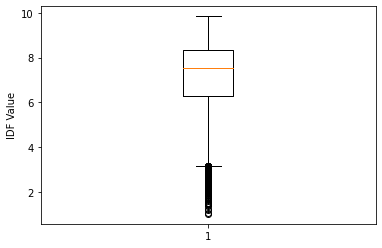

In [ ]:
# box plot to decide the threshold
plt.boxplot(vectorizer.idf_)
plt.ylabel("IDF Value")

In [ ]:
# sortedDiff =np.sort(diff)
for i in range (0,101,10):
    p = np.percentile(vectorizer.idf_, i)
    print(str(i)+" Percentile: "+ str(p))

0 Percentile: 1.0077317773707817
10 Percentile: 4.961189206264439
20 Percentile: 5.876176147118889
30 Percentile: 6.59925919512169
40 Percentile: 7.108907655714666
50 Percentile: 7.5442257269725115
60 Percentile: 7.887997266075336
70 Percentile: 8.201654824930378
80 Percentile: 8.50703647448156
90 Percentile: 8.7789701899652
100 Percentile: 9.846810819966556


In [ ]:
min_threshold = 3 # np.percentile(vectorizer.idf_, 20)
max_threshold = np.percentile(vectorizer.idf_, 90)
print(min_threshold, max_threshold)

3 8.7789701899652


In [ ]:
feat = vectorizer.get_feature_names()
idf_val = vectorizer.idf_
len(feat), len(idf_val)
feat_idf_dict = dict(zip(feat, idf_val))

In [ ]:
# new_data = {k: v for k, v in feat_idf_dict.iteritems() if min_threshold < v[0] < max_threshold}
for k  in list(feat_idf_dict.keys()):
    # removing low and high idf features
    if (min_threshold >= feat_idf_dict[k]) or (feat_idf_dict[k] >= max_threshold):
        feat_idf_dict.pop(k)

len(feat_idf_dict)

8831

In [ ]:
import tqdm
# removing low and high idf words from dataset
def get_filtered_text(text_dataset):

    
  filtered_text = []

  for text in (text_dataset):
    resultwords  = [word for word in text.split() if word.lower() in list(feat_idf_dict.keys())]
    result = ' '.join(resultwords)
    filtered_text.append(result)
    
  return filtered_text

In [ ]:

x_train_essay_text_filtered = get_filtered_text(x_train_essay_text)
saveModel("x_train_tfidf_filter_3.pkl", x_train_essay_text_filtered)


#x_train_essay_text_filtered = getModel("x_train_tfidf_filter_3.pkl")
#x_test_essay_text_filtered = getModel("x_test_tfidf_filter_3.pkl")

In [ ]:
x_test_essay_text_filtered = get_filtered_text(x_test_essay_text)
saveModel("x_test_tfidf_filter_3.pkl", x_test_essay_text_filtered)


In [ ]:
x_train_essay_text_filtered = getModel("x_train_tfidf_filter_3.pkl")
x_test_essay_text_filtered = getModel("x_test_tfidf_filter_3.pkl")

In [ ]:
# tokenizing 
t = Tokenizer()
t.fit_on_texts(x_train_essay_text_filtered)
vocab_size = len(t.word_index) + 1
print(len(t.word_index))

8831


In [ ]:
def load_embedding(filename):

    # load embedding into memory, skip first line
    file = open(filename, 'r')
    lines = file.readlines()[1:]
    
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

# load embedding from file
raw_embedding = load_embedding('/content/drive/My Drive/AAIC assingments/glove.6B.300d.txt')
# raw_embedding = load_embedding('glove.42B.300d.txt')

# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, t.word_index)
where_are_NaNs = np.isnan(embedding_vectors)
embedding_vectors[where_are_NaNs] = 0


In [ ]:
# Train
# enocde it to sequences
encoded_docs = t.texts_to_sequences(x_train_essay_text_filtered)
max_length = len(max(x_train_essay_text_filtered, key=len).split(' '))
x_train_text_M2 = sequence.pad_sequences(encoded_docs, maxlen = max_length, padding='post')
x_train_text_M2.shape

# Test
encoded_docs = t.texts_to_sequences(x_test_essay_text_filtered)
x_test_text_M2 = sequence.pad_sequences(encoded_docs, maxlen = max_length, padding='post')
x_test_text_M2.shape

(32775, 216)

In [ ]:
x_train_text_M2.shape

(76473, 216)

In [ ]:
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auroc(y_true, y_pred):
    # print(y_true, y_pred)
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
#input 1
input_1 = Input(shape=(216,))
x1 =Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=x_train_text_M2.shape[1], trainable=False)(input_1)
x1 = Dropout(0.4)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input_2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52, output_dim= 2)(input_2)
x2 = Flatten()(x2)

#input 3
input_3 = Input(shape=(1,))
x3 = Embedding(input_dim = 5, output_dim= 2)(input_3)
x3 = Flatten()(x3)

#input 4
input_4 = Input(shape=(1,))
x4 = Embedding(input_dim=52,output_dim= 2)(input_4)
x4 = Flatten()(x4)

#input 5
input_5 = Input(shape=(1,))
x5 = Embedding(input_dim= 396, output_dim= 64)(input_5)
x5 = Flatten()(x5)

#input 6
input_6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 4)(input_6)
x6 = Flatten()(x6)

#input 7
input_7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input_7)

#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128, activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# model with all the inputs
model = Model([input_1, input_2, input_3, input_4, input_5, input_6, input_7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
print(model.summary())



Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 216)]        0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 216, 300)     2649600     input_30[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 216, 300)     0           embedding_25[0][0]               
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 1)]          0                                            
_______________________________________________________________________________________

In [ ]:
from keras.utils import to_categorical
y_train = train_df.project_is_approved.values.tolist()
y_test = test_df.project_is_approved.values.tolist()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
x_train =  [x_train_text_M2, x_train_sch_state, x_train_proj_grade, x_train_clean_cat, x_train_clean_sub_cat, x_train_teacher_prefix, x_train_previously_posted_projects]
x_test = [x_test_text_M2, x_test_sch_state, x_test_proj_grade, x_test_clean_cat, x_test_clean_sub_cat, x_test_teacher_prefix, x_test_previously_posted_projects]

In [ ]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath = "weight_model2_v3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
model.fit(x_train, y_train, epochs=20,verbose=1,batch_size=128, callbacks =callbacks_list)
model.save('dc_model2_v4.h5')


Epoch 1/20
598/598 [==============================] - 19s 32ms/step - loss: 0.5670 - auroc: 0.5609
Epoch 2/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4715 - auroc: 0.6352
Epoch 3/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4455 - auroc: 0.6716
Epoch 4/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4311 - auroc: 0.6887
Epoch 5/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4224 - auroc: 0.6963
Epoch 6/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4149 - auroc: 0.7046
Epoch 7/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4099 - auroc: 0.7132
Epoch 8/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4063 - auroc: 0.7179
Epoch 9/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4033 - auroc: 0.7231
Epoch 10/20
598/598 [==============================] - 19s 32ms/step - loss: 0.4042 - auroc: 0.7246
Epoch 11/

In [ ]:
### Testing model-2
y_train_pred = model.predict(x_train)
print("Train AUC:",roc_auc_score(y_train,y_train_pred))

Train AUC: 0.8691214777601453


In [ ]:
y_test_pred = model.predict(x_test)
print("Test AUC:",roc_auc_score(y_test,y_test_pred))

Test AUC: 0.7164262407988157


# model 3



In [ ]:
# http://flovv.github.io/Embeddings_with_keras_part2/
# school state
token = CountVectorizer()
# integer encode the documents
x_train_sch_state = token.fit_transform(train_df.school_state)
x_test_sch_state = token.transform(test_df.school_state)
print(x_train_sch_state.shape, x_test_sch_state.shape)

(76473, 51) (32775, 51)
(76473, 51) (32775, 51)


In [ ]:
# proj_grade
token = CountVectorizer()
# integer encode the documents
x_train_proj_grade = token.fit_transform(train_df.project_grade_category)
x_test_proj_grade = token.transform(test_df.project_grade_category)
print(x_train_proj_grade.shape, x_test_proj_grade.shape)

(76473, 4) (32775, 4)


In [ ]:
# clean_cat
token = CountVectorizer()
# integer encode the documents
x_train_clean_cat = token.fit_transform(train_df.clean_categories)
x_test_clean_cat = token.transform(test_df.clean_categories)
print(x_train_clean_cat.shape, x_test_clean_cat.shape)

(76473, 9) (32775, 9)


In [ ]:
# x_train_clean_sub_cat
token = CountVectorizer()
# integer encode the documents
x_train_clean_sub_cat = token.fit_transform(train_df.clean_subcategories)
x_test_clean_sub_cat = token.transform(test_df.clean_subcategories)
print(x_train_clean_sub_cat.shape, x_test_clean_sub_cat.shape)

(76473, 30) (32775, 30)


In [ ]:
# x_train_teacher_prefix
token = CountVectorizer()
# integer encode the documents
x_train_teacher_prefix = token.fit_transform(train_df.teacher_prefix)
x_test_teacher_prefix = token.transform(test_df.teacher_prefix)
print(x_train_teacher_prefix.shape, x_test_teacher_prefix.shape)

(76473, 5) (32775, 5)


In [ ]:
x_train_previously_posted_projects = train_df.teacher_number_of_previously_posted_projects.values
x_train_previously_posted_projects = x_train_previously_posted_projects.reshape(76473, 1)
#x_train_previously_posted_projects.shape
x_test_previously_posted_projects = test_df.teacher_number_of_previously_posted_projects.values
x_test_previously_posted_projects = x_test_previously_posted_projects.reshape(32775, 1)
print(x_train_previously_posted_projects.shape, x_test_previously_posted_projects.shape)

(76473, 1) (32775, 1)


In [ ]:
### input_1
x_train_1 =  x_train_text
x_test_1 =  x_test_text

In [ ]:
### input 2
x_train_2 = hstack((x_train_sch_state, x_train_proj_grade, x_train_clean_cat, x_train_clean_sub_cat, x_train_teacher_prefix, x_train_previously_posted_projects)).todense()
x_train_2 = np.array(x_train_2).reshape(x_train_2.shape[0],x_train_2.shape[1],1)

x_test_2 = hstack((x_test_sch_state, x_test_proj_grade, x_test_clean_cat, x_test_clean_sub_cat, x_test_teacher_prefix, x_test_previously_posted_projects)).todense()
x_test_2 = np.array(x_test_2).reshape(x_test_2.shape[0],x_test_2.shape[1],1)

x_train_2.shape, x_test_2.shape

((76473, 100, 1), (32775, 100, 1))

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
#     print(y_true, y_pred)
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
from keras.layers import LeakyReLU

In [ ]:
# input 1
input_1 = Input(shape=(328,))
x1 =Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=x_train_text.shape[1], trainable=False)(input_1)
x1 = Dropout(0.5)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input_2 = Input(shape=(100,1))
x2 = Conv1D(filters=128,kernel_size=3, strides=1)(input_2)
x2 = Conv1D(filters=64,kernel_size=3, strides=1)(x2)
x2 = Flatten()(x2)


# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.3)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input_1,input_2], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
print(model.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 328)]        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 328, 300)     14726100    input_22[0][0]                   
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 328, 300)     0           embedding_13[0][0]               
_______________________________________________________________________________________

In [ ]:
from keras.utils import to_categorical
y_train = train_df.project_is_approved.values.tolist()
y_test = test_df.project_is_approved.values.tolist()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
x_train = [x_train_1, x_train_2]
x_test  = [x_test_1, x_test_2]

In [ ]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath = "weight_model2_v3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
model.fit(x_train, y_train, epochs=10,verbose=1,batch_size=128, callbacks =callbacks_list)
# model.save('dc_model3.h5')

Epoch 1/10
598/598 [==============================] - 27s 45ms/step - loss: 0.6586 - auroc: 0.5123
Epoch 2/10
598/598 [==============================] - 27s 45ms/step - loss: 0.5033 - auroc: 0.5422
Epoch 3/10
598/598 [==============================] - 27s 45ms/step - loss: 0.4704 - auroc: 0.5893
Epoch 4/10
598/598 [==============================] - 27s 45ms/step - loss: 0.4540 - auroc: 0.6178
Epoch 5/10
598/598 [==============================] - 27s 45ms/step - loss: 0.4343 - auroc: 0.6736
Epoch 6/10
598/598 [==============================] - 27s 46ms/step - loss: 0.4241 - auroc: 0.6943
Epoch 7/10
598/598 [==============================] - 27s 46ms/step - loss: 0.4173 - auroc: 0.7043
Epoch 8/10
598/598 [==============================] - 27s 46ms/step - loss: 0.4131 - auroc: 0.7138
Epoch 9/10
598/598 [==============================] - 28s 46ms/step - loss: 0.4081 - auroc: 0.7231
Epoch 10/10
598/598 [==============================] - 28s 46ms/step - loss: 0.4062 - auroc: 0.7261


In [ ]:
### Testing model-3
y_train_pred = model.predict(x_train)
print("Train AUC:",roc_auc_score(y_train,y_train_pred))

y_test_pred = model.predict(x_test)
print("Test AUC:",roc_auc_score(y_test,y_test_pred))

Train AUC: 0.7649194737974336
Test AUC: 0.7428319644116362


# CONCLUSION

In [ ]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Architecture", "Train AUC", "Test AUC"]
x.add_row(["Model-1", "0.84", "0.75"])
x.add_row(["Model-2", "0.86", "0.71"])
x.add_row(["Model-3", "0.76", "0.74"])
print(x)

+--------------+-----------+----------+
| Architecture | Train AUC | Test AUC |
+--------------+-----------+----------+
|   Model-1    |    0.84   |   0.75   |
|   Model-2    |    0.86   |   0.71   |
|   Model-3    |    0.76   |   0.74   |
+--------------+-----------+----------+
